In [1]:
"""
@Description :   Machine learning方法实现
@Author      :   Xubo Luo 
@Time        :   2024/01/09 21:35:36
"""

import argparse
import os
import cv2
import math
import time
import numpy as np
import tqdm
from utils.data_utils import load_CIFAR10
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import _pickle as pickle
import matplotlib.pyplot as plt

## 定义类

In [2]:
class Classifier(object):
    def __init__(self, filePath, classifier='linear_svm', is_hog=False, is_save=False):
        self.filePath = filePath
        self.type = classifier
        self.is_save = is_save
        self.is_hog = is_hog
        if classifier == 'linear_svm':
            self.classifier = LinearSVC()
        elif classifier == 'kernel_svm':
            self.classifier = SVC(kernel='rbf', C=1, gamma='scale')
        elif classifier == 'gaussian_nb':
            self.classifier = GaussianNB()

    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    
    def load_CIFAR(self):
        X_train, y_train, X_test, y_test = load_CIFAR10(self.filePath)
        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        return X_train, y_train, X_test, y_test
    
    def get_data(self):
        TrainData = []
        TestData = []
        for b in range(1,6):
            f = os.path.join(self.filePath, 'data_batch_%d' % (b, ))
            data = self.unpickle(f)
            train = np.reshape(data[b'data'], (10000, 3, 32 * 32))
            labels = np.reshape(data[b'labels'], (10000, 1))
            fileNames = np.reshape(data[b'filenames'], (10000, 1))
            datalebels = zip(train, labels, fileNames)
            TrainData.extend(datalebels)
        f = os.path.join(self.filePath,'test_batch')
        data = self.unpickle(f)
        test = np.reshape(data[b'data'], (10000, 3, 32 * 32))
        labels = np.reshape(data[b'labels'], (10000, 1))
        fileNames = np.reshape(data[b'filenames'], (10000, 1))
        TestData.extend(zip(test, labels, fileNames))

        print("Data reading finished!")
        return TrainData, TestData
 
    def get_hog_feat(self, image, stride=8, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        cx, cy = pixels_per_cell
        bx, by = cells_per_block
        sx, sy = image.shape
        n_cellsx = int(np.floor(sx // cx))  # number of cells in x
        n_cellsy = int(np.floor(sy // cy))  # number of cells in y
        n_blocksx = (n_cellsx - bx) + 1
        n_blocksy = (n_cellsy - by) + 1
        gx = np.zeros((sx, sy), dtype=np.float32)
        gy = np.zeros((sx, sy), dtype=np.float32)
        eps = 1e-5
        grad = np.zeros((sx, sy, 2), dtype=np.float32)
        for i in range(1, sx-1):
            for j in range(1, sy-1):
                gx[i, j] = image[i, j-1] - image[i, j+1]
                gy[i, j] = image[i+1, j] - image[i-1, j]
                grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
                if gx[i, j] < 0:
                    grad[i, j, 0] += 180
                grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
                grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)
        normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
        for y in range(n_blocksy):
            for x in range(n_blocksx):
                block = grad[y*stride:y*stride+16, x*stride:x*stride+16]
                hist_block = np.zeros(32, dtype=np.float32)
                eps = 1e-5
                for k in range(by):
                    for m in range(bx):
                        cell = block[k*8:(k+1)*8, m*8:(m+1)*8]
                        hist_cell = np.zeros(8, dtype=np.float32)
                        for i in range(cy):
                            for j in range(cx):
                                n = int(cell[i, j, 0] / 45)
                                hist_cell[n] += cell[i, j, 1]
                        hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
                normalised_blocks[y, x, :] = hist_block / np.sqrt(hist_block.sum() ** 2 + eps)
        return normalised_blocks.ravel()
 
    def get_feat(self, TrainData, TestData):
        train_feat = []
        test_feat = []
        for data in tqdm.tqdm(TestData):
            image = np.reshape(data[0].T, (32, 32, 3))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255.
            fd = self.get_hog_feat(gray)
            # fd = hog(gray, 9, [8, 8], [2, 2])
            fd = np.concatenate((fd, data[1]))
            test_feat.append(fd)
        test_feat = np.array(test_feat)
        np.save("caches/test_feat.npy", test_feat)
        print("Test features are extracted and saved.")
        for data in tqdm.tqdm(TrainData):
            image = np.reshape(data[0].T, (32, 32, 3))
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
            fd = self.get_hog_feat(gray)
            # fd = hog(gray, 9, [8, 8], [2, 2])
            fd = np.concatenate((fd, data[1]))
            train_feat.append(fd)
        train_feat = np.array(train_feat)
        np.save("caches/train_feat.npy", train_feat)
        print("Train features are extracted and saved.")
        return train_feat, test_feat
 
    def classification(self, train_feat, test_feat):
        # 训练模型
        print("\nTraining the %s classifier."%self.type)
        tik = time.time()
        self.classifier.fit(train_feat[:, :-1], train_feat[:, -1])
        tok = time.time()
        print("Training finished.")
        print("Time cost: %f\n" % (tok - tik))

        # 保存模型
        if self.is_save:
            with open('caches/%s_hog.pkl'%self.type, 'wb') as f:
                pickle.dump(self.classifier, f)
        
        # 测试模型
        predict_result = self.classifier.predict(test_feat[:, :-1])
        acc = np.mean(predict_result == test_feat[:, -1])
        print('Testing accuracy: %f'%acc)
    
    def run(self):
        if not self.is_hog:
            """
            不使用hog特征的情况，因为逻辑比较简单，所以没有写单独的处理函数
            """
            # 读取数据
            X_train, y_train, X_test, y_test = self.load_CIFAR()
            # 训练
            print('Beign to train the %s classifier ...'%self.type)
            tik = time.time()
            self.classifier.fit(X_train, y_train)
            tok = time.time()
            print("Training finished. Time cost: %f\n" % (tok - tik))
            # 保存模型
            if self.is_save:
                with open('caches/%s.pkl'%self.type, 'wb') as f:
                    pickle.dump(self.classifier, f)
            # 测试
            print('Beign to test the %s classifier ...'%self.type)
            predict_result = self.classifier.predict(X_test)
            acc = np.mean(predict_result == y_test)
            print('The testing classification accuracy is %f' % acc)
        else:
            """
            使用hog特征的情况
            """
            # 加载caches中已经提取好的hog特征
            if os.path.exists("caches/train_feat.npy") and os.path.exists("caches/test_feat.npy"):
                train_feat = np.load("caches/train_feat.npy")
                test_feat = np.load("caches/test_feat.npy")
            # 或者重新提取hog特征
            else:
                TrainData, TestData = self.get_data()
                train_feat, test_feat = self.get_feat(TrainData, TestData)
            # 训练和测试
            self.classification(train_feat, test_feat)

## 导入数据集

In [6]:
filePath = '../../cifar-10-python/cifar-10-batches-py'

X_train, y_train, X_test, y_test = load_CIFAR10('../../cifar-10-python/cifar-10-batches-py')

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


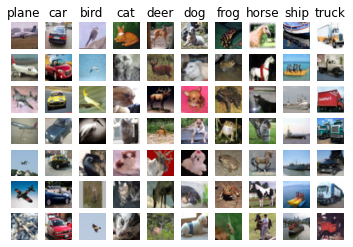

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
#     print(y, cls)
    idxs = np.flatnonzero(y_train == y)
#     print(idxs)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
#     print(idxs)
    for i, idx in enumerate(idxs):
#         print(i, idx)
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## w/o HOG

In [ ]:
## Linear SVM
cf = LinearSVC()
tik = time.time()
cf.fit(X_train, y_train)
tok = time.time()
print("Training finished. Time cost: %f\n" % (tok - tik))
y_pred = cf.predict(X_test)
acc = np.mean(y_pred == y_test)
print('Linear SVM acc: %f'%acc)

In [ ]:
## Kernel SVM
cf = SVC(kernel='rbf', C=1, gamma='scale')
tik = time.time()
cf.fit(X_train, y_train)
tok = time.time()
print("Training finished. Time cost: %f\n" % (tok - tik))
y_pred = cf.predict(X_test)
acc = np.mean(y_pred == y_test)
print('Kernel SVM acc: %f'%acc)

## w/ HOG

In [ ]:
## Linear SVM
cf = Classifier(filePath, classifier='linear_svm', is_hog = 1, is_save=0)
cf.run()

## Kernel SVM
cf = Classifier(filePath, classifier='kernel_svm', is_hog = 1, is_save=0)
cf.run()

## Linear SVM w/o HOG

In [7]:
cf = LinearSVC()
tik = time.time()
cf.fit(X_train, y_train)
tok = time.time()
print("Training finished. Time cost: %f\n" % (tok - tik))
y_pred = cf.predict(X_test)
acc = np.mean(y_pred == y_test)
print('LinearSVC acc: %f'%acc)

## Linear SVM w/ HOG

In [ ]:
cf = Classifier(filePath, classifier='linear_svm', is_hog = 0, is_save=0)
cf.run()

## Kernel SVM w/o HOG

In [ ]:
cf = Classifier(filePath, classifier='kernel_svm', is_hog = 1, is_save=0)
cf.run()

## Kernel SVM w/ HOG

In [ ]:
cf = Classifier(filePath, classifier='kernel_svm', is_hog =1, is_save=0)
cf.run()